In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import pickle
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
print(f"TensorFlow Version: {tf.__version__}")

TensorFlow Version: 2.16.1


In [3]:
# Load numpy array
data = np.load('./AP_data/age_data_images_100_100.pickle', allow_pickle=True)
df = pd.DataFrame(data)

In [4]:
def group_age(example):
    example['age'] = example['age'].apply(lambda x: "0-10" if 0 < x <= 10 
                                          else "10-20" if 10 < x <= 20 
                                          else "20-30" if 20 < x <= 30 
                                          else "30-40" if 30 < x <= 40
                                          else "40-50" if 40 < x <= 50
                                          else "50-60" if 50 < x <= 60
                                          else "60-70" if 60 < x <= 70
                                          else "70-80" if 70 < x <= 80
                                          else "80-90" if 80 < x <= 90
                                          else "90-100" if 90 < x <= 100
                                          else "100+")

In [5]:
group_age(data)

In [6]:
data.head()

,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,pixel_9,...,pixel_9991,pixel_9992,pixel_9993,pixel_9994,pixel_9995,pixel_9996,pixel_9997,pixel_9998,pixel_9999,age
0,0.188235,0.223529,0.184314,0.235294,0.254902,0.098039,0.039216,0.058824,0.109804,0.094118,...,0.000000,0.000000,0.003922,0.007843,0.007843,0.007843,0.003922,0.007843,0.015686,90-100
1,0.431373,0.466667,0.474510,0.478431,0.505882,0.533333,0.560784,0.572549,0.556863,0.607843,...,0.462745,0.337255,0.396078,0.450980,0.419608,0.419608,0.411765,0.415686,0.423529,90-100
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,90-100
3,0.235294,0.219608,0.192157,0.184314,0.184314,0.192157,0.207843,0.266667,0.337255,0.423529,...,0.701961,0.705882,0.709804,0.705882,0.698039,0.709804,0.705882,0.725490,0.729412,20-30
4,0.047059,0.047059,0.050980,0.058824,0.054902,0.054902,0.054902,0.054902,0.070588,0.082353,...,0.200000,0.188235,0.172549,0.176471,0.172549,0.180392,0.200000,0.219608,0.227451,20-30


In [7]:
from sklearn.preprocessing import LabelEncoder

X = data.drop('age', axis=1).values.reshape(-1, 100, 100, 1)  # Reshape for CNN input (add 1 channel)
y = data['age'].values

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (7822, 100, 100, 1), y_train shape: (7822,)
X_test shape: (1956, 100, 100, 1), y_test shape: (1956,)


In [8]:
with open('./AP_data/label_encoder.pkl', 'wb') as file:
    pickle.dump(label_encoder, file)

In [ ]:
# X = df.drop('age', axis=1).values  # PCA data with 50 components
# y = df['age'].values  # Target or dependent variable (age)

# # Reshape X to 4D tensor for CNN
# X = X.reshape(X.shape[0], 100, 100, 1)

# print(X.shape, y.shape)

In [5]:
# # Split the data into train and test
# x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)


(4744, 100, 100, 1) (1186, 100, 100, 1) (4744,) (1186,)


In [19]:
# # Build the CNN model
# def create_cnn_model(input_shape):
#     model = Sequential()
#     model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
#     model.add(MaxPooling2D((2, 2)))
#     model.add(Dropout(0.25))
    
#     model.add(Conv2D(64, (3, 3), activation='relu'))
#     model.add(MaxPooling2D((2, 2)))
#     model.add(Dropout(0.25))
    
#     model.add(Conv2D(128, (3, 3), activation='relu'))
#     model.add(MaxPooling2D((2, 2)))
#     model.add(Dropout(0.25))
    
#     model.add(Flatten())
#     model.add(Dense(256, activation='relu'))
#     model.add(Dropout(0.5))
    
#     model.add(Dense(1, activation='linear'))  # Regression output
#     model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
#     return model

# input_shape = (100, 100, 1)
# model = create_cnn_model(input_shape)
# model.summary()


In [9]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical

# Convert labels to one-hot encoding
num_classes = len(np.unique(y))
y_train_cat = to_categorical(y_train, num_classes)
y_test_cat = to_categorical(y_test, num_classes)

# Define the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(100, 100, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')  # Softmax for classification
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()


c:\Aafrith\Age-prediction-Model\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 98, 98, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 49, 49, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 47, 47, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 21, 21, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,638,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 11)             │         1,419 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,732,619 (6.61 MB)

 Trainable params: 1,732,619 (6.61 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# Train the model
history = model.fit(X_train, y_train_cat, epochs=20, batch_size=32, validation_data=(X_test, y_test_cat))

Epoch 1/20
245/245 ━━━━━━━━━━━━━━━━━━━━ 40s 154ms/step - accuracy: 0.3490 - loss: 1.9191 - val_accuracy: 0.4760 - val_loss: 1.4542
Epoch 2/20
245/245 ━━━━━━━━━━━━━━━━━━━━ 37s 151ms/step - accuracy: 0.4554 - loss: 1.4642 - val_accuracy: 0.5189 - val_loss: 1.3004
Epoch 3/20
245/245 ━━━━━━━━━━━━━━━━━━━━ 38s 155ms/step - accuracy: 0.4986 - loss: 1.3254 - val_accuracy: 0.5419 - val_loss: 1.2332
Epoch 4/20
245/245 ━━━━━━━━━━━━━━━━━━━━ 38s 157ms/step - accuracy: 0.5301 - loss: 1.2208 - val_accuracy: 0.5445 - val_loss: 1.2364
Epoch 5/20
245/245 ━━━━━━━━━━━━━━━━━━━━ 38s 157ms/step - accuracy: 0.5425 - loss: 1.1608 - val_accuracy: 0.5685 - val_loss: 1.1545
Epoch 6/20
245/245 ━━━━━━━━━━━━━━━━━━━━ 39s 160ms/step - accuracy: 0.5639 - loss: 1.0958 - val_accuracy: 0.5741 - val_loss: 1.1368
Epoch 7/20
245/245 ━━━━━━━━━━━━━━━━━━━━ 39s 159ms/step - accuracy: 0.5838 - loss: 1.0311 - val_accuracy: 0.5741 - val_loss: 1.1377
Epoch 8/20
245/245 ━━━━━━━━━━━━━━━━━━━━ 40s 162ms/step - accuracy: 0.5978 - loss: 1

In [13]:
# # Train the model
# history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=32, batch_size=32)

# # Save the trained model
# model.save('./AP_model/model_cnn.h5')


In [14]:
# # Model Evaluation
# y_pred = model.predict(x_test).flatten()

# # Mean Absolute Error
# mae = mean_absolute_error(y_test, y_pred)
# print(f"Mean Absolute Error (MAE): {mae}")

# # Mean Squared Error
# mse = mean_squared_error(y_test, y_pred)
# print(f"Mean Squared Error (MSE): {mse}")

# # Root Mean Squared Error
# rmse = np.sqrt(mse)
# print(f"Root Mean Squared Error (RMSE): {rmse}")

# # R^2 Score
# r2 = r2_score(y_test, y_pred)
# print(f"R^2 Score: {r2}")


62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.5721 - loss: 1.2842
Test Accuracy: 0.588445782661438


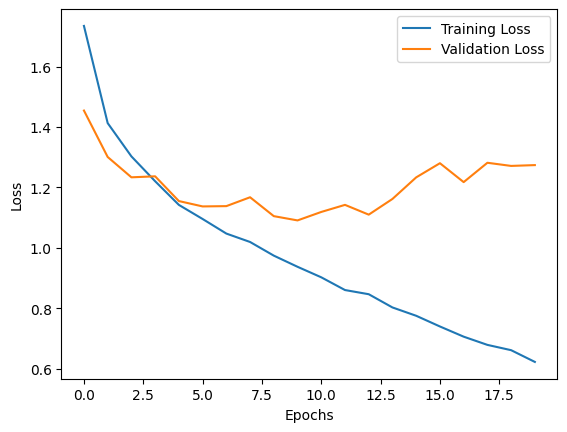

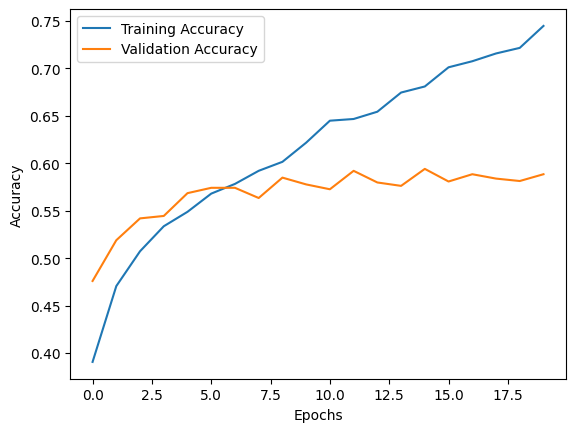

In [11]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test_cat)
print(f"Test Accuracy: {accuracy}")

# Plot training history
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [18]:
# # Visualize training history
# plt.figure(figsize=(12, 4))
# plt.subplot(1, 2, 1)
# plt.plot(history.history['loss'], label='Training Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.title('Loss Over Epochs')

# plt.subplot(1, 2, 2)
# plt.plot(history.history['mae'], label='Training MAE')
# plt.plot(history.history['val_mae'], label='Validation MAE')
# plt.xlabel('Epochs')
# plt.ylabel('MAE')
# plt.legend()
# plt.title('MAE Over Epochs')

# plt.show()


In [12]:
model.save('./AP_model/classification_model_cnn.h5')

In [13]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
import pickle

# Load the Haar Cascade Classifier
haar_cascade = cv2.CascadeClassifier('./AP_model/haarcascade_frontalface_default.xml')


# Load the model
model = load_model('./AP_model/classification_model_cnn.h5')

# Load the label encoder
with open('./AP_data/label_encoder.pkl', 'rb') as file:
    label_encoder = pickle.load(file)

# Function to detect faces
def detect_faces(image_path):
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Image at path {image_path} could not be loaded.")
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = haar_cascade.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=5)
    
    return faces, img, gray

# Function to preprocess the face image
def preprocess_face(face_image):
    img_resized = cv2.resize(face_image, (100, 100))
    img_normalized = img_resized / 255.0
    img_reshaped = img_normalized.reshape(1, 100, 100, 1)
    return img_reshaped

# Function to predict the age class of detected faces
def predict_age_class(image_path, model, label_encoder):
    faces, img, gray = detect_faces(image_path)
    predictions = []
    
    for (x, y, w, h) in faces:
        face = gray[y:y+h, x:x+w]
        preprocessed_face = preprocess_face(face)
        prediction = model.predict(preprocessed_face)
        predicted_class_index = np.argmax(prediction, axis=1)[0]
        predicted_age_range = label_encoder.inverse_transform([predicted_class_index])[0]
        predictions.append((x, y, w, h, predicted_age_range))
    
    return predictions, img

# Function to draw bounding boxes and predicted age classes on the image
def draw_predictions(image_path, predictions):
    img = cv2.imread(image_path)
    for (x, y, w, h, age_range) in predictions:
        cv2.rectangle(img, (x, y), (x+w, y+h), (255, 0, 0), 2)
        cv2.putText(img, age_range, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)
    return img

# Example usage



In [14]:
image_path = './test_images/getty_test.jpg'
predictions, original_image = predict_age_class(image_path, model, label_encoder)
output_image = draw_predictions(image_path, predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


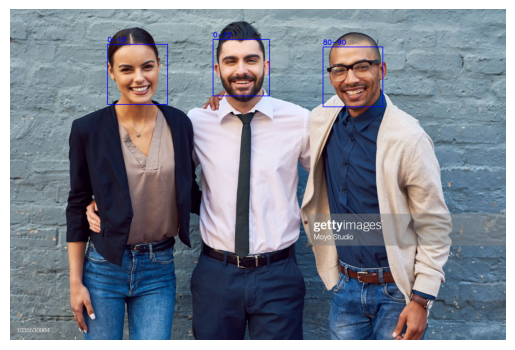

In [15]:
# Display the output image with bounding boxes and predicted age classes
import matplotlib.pyplot as plt

plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()